# Depression Forum Exploration 

In [1]:
import numpy as np  
import pandas as pd
import gensim as gs
import re, collections
import random
import nltk as nltk

from nltk.corpus import words
from nltk.corpus import gutenberg
from datetime import datetime
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from itertools import groupby

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


## List of Drug Names

In [2]:
from bs4 import BeautifulSoup as bs
soup = bs(open("CNSDrug_groupings_tm_rp.csv", "r"))
drugTags = soup.findAll('td')[3::4]
drugList = [drug.getText() for drug in drugTags]

## Consumer Health Vocab and Brand Name Drugs

In [3]:
chv = pd.read_csv("chv_category.csv", sep="\t")

In [4]:
brandNameDrugs = pd.read_csv("brandNameDrugs.csv", sep="\t")

In [33]:
rxlist = pd.read_csv("rxlist.csv")

## Read in Text Data for Given Drug

In [148]:
from os import listdir
from os.path import isfile, join

In [149]:
listdir("dataByDrug")

['abilify.csv',
 'celexa_lexapro.csv',
 'cymbalta.csv',
 'effexor.csv',
 'general.csv',
 'latuda.csv',
 'other.csv',
 'paxil.csv',
 'prozac.csv',
 'remeron.csv',
 'viibryd.csv',
 'wellbutrin.csv',
 'zoloft.csv']

In [153]:
fileList = listdir("dataByDrug")

In [195]:
allData = pd.DataFrame()
for csv in fileList:
    data = pd.read_csv("dataByDrug/" + csv)
    print("dataByDrug/" + csv)
    data = data[pd.notnull(data['text'])]
    #clPosts = cl[~cl["pageID"].str.contains("A-Z", case=False)]
    firstPostData = data[data['pageNum'] == 1]
    firstPostData = firstPostData[firstPostData['postNum'] == 1]
    allData = allData.append(firstPostData, ignore_index=True)

dataByDrug/abilify.csv
dataByDrug/celexa_lexapro.csv
dataByDrug/effexor.csv
dataByDrug/general.csv
dataByDrug/latuda.csv
dataByDrug/other.csv
dataByDrug/paxil.csv
dataByDrug/prozac.csv
dataByDrug/remeron.csv
dataByDrug/viibryd.csv
dataByDrug/wellbutrin.csv
dataByDrug/zoloft.csv


## Corpus Construction

In [196]:
# Constants for anchoring dosages

dosageTermList = ["mg", "mgs", "mg/day", "mgs/day"]

In [197]:
# drug spellings not in our default drug list 

additionalDrugs = ['lexapro', 'celexa', 'cipramil', 'seropram', 'cipralex', 'prozac', 'luvox', 'remeron', 'mirtazapine', 
                   'serzone', 'nefazodone', 'campral', 'acamprosate', 'ativan', 'klonopin']

In [198]:
# additional words

additionalWords = ['ssri', 'depressant', 'dosage', 'dose', 'posting', 'therapy', 
                   'guys', 'gym', 'ssri', 'combo', 'overall', 'motivation', 'basically'
                   'switched', 'catatonic', 'paranoia', 'meds']

In [199]:
# lambda function to grab first term in string

def getFirstWord(text):
    text = re.findall(r"[\w']+", text.lower())
    return text[0]

In [200]:
# generic drug names and brand drug names

brandNameDrugsList = brandNameDrugs["Brand Name"].apply(lambda row: getFirstWord(row))  
genericDrugNameList = brandNameDrugs["Generic Name"].apply(lambda row: getFirstWord(row)) 

In [201]:
# list of stopwords that we don't care about

stopwords = get_stop_words('en')

In [202]:
#word_list = words.words()
wordList = []
for fileid in gutenberg.fileids():
    wordList = wordList + list(gutenberg.words(fileid))

In [203]:
# grab symptoms and add to vocabulary

chvSymptoms = chv[chv['category_name'] == 'Sign or Symptom']

chvSymptomTerms = chvSymptoms['term'].astype(str).tolist()

# get other vocabulary 
chvOther = chv[(chv['category_name'] == 'Finding') | (chv['category_name'] == 'Body Part') | 
               (chv['category_name'] == 'Disease or Syndrome') | (chv['category_name'] == 'Congenital Abnormality')| 
               (chv['category_name'] == 'Congenital Abnormality') | (chv['category_name'] == 'Body Part')]

chvOtherTerms = chvOther['term'].astype(str).tolist()

# grab brand/generics and add
brandNameDrugsList = brandNameDrugsList.astype(str).tolist()
genericDrugNameList = genericDrugNameList.astype(str).tolist()
rxBrandNameDrugsList = rxlist['brandNameDrug'].astype(str).tolist()
rxMedicalDrugNameList = rxlist['medicalDrugName'].astype(str).tolist()

def words(text): 
    text = ' '.join(text) + " i " + ' '.join(additionalDrugs + dosageTermList + chvSymptomTerms + drugList + stopwords + 
                                             additionalWords + brandNameDrugsList + genericDrugNameList + chvOtherTerms +
                                             rxbrandNameDrugsList + rxMedicalDrugNameList) 
    return re.findall(r'\w+', text.lower())

WORDS = Counter(words(wordList))

## Spell Checker Code

In [204]:
# function that reduces excessive letter repetition

def reduceMultiLetters(text): 
    return(''.join(''.join(s)[:2] for _, s in groupby(text)))

In [205]:
# initialize set of words we know are correct

cachedWords = set()

In [206]:
# check if word is in our set of correctly spelled words

def isSpelledCorrectly(word):
    if word in cachedWords:
        return True
    else:
        return False

In [207]:
# spell checking functions

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
    s = [(word[:i], word[i:]) for i in range(len(word) + 1)]
    deletes    = [a + b[1:] for a, b in s if b]
    transposes = [a + b[1] + b[0] + b[2:] for a, b in s if len(b)>1]
    replaces   = [a + c + b[1:] for a, b in s for c in alphabet if b]
    inserts    = [a + c + b     for a, b in s for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in WORDS)

def known(words):
    return set(w for w in words if w in WORDS)

# main function that you call to correct a word
def correct(word):
    if isSpelledCorrectly(word):
        return word
    else:
        candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
        bestGuess = max(candidates, key=WORDS.get)
        cachedWords.add(bestGuess)
        return bestGuess

## Dosage and Helper Functions

In [208]:
# checks if a string is a number

def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [209]:
# function that joins together dosage terms as one term

def collateDosages(text):
    lastWord = ""
    newText = []
    if type(text) == list:
        print(text)
    text = re.findall(r"[\w']+", text)
    for word in text:
        if (word in dosageTermList) and isNumber(lastWord): 
            newText.pop()
            newText.append(lastWord + word)
            lastWord = ""
        else:
            lastWord = word 
            newText.append(word)
    return(" ".join(newText))

## Spell Checking and Feature Extraction Preparation

In [210]:
# lambda functions for feature extraction

def getDerivedRow(row):
    text = reduceMultiLetters(row['text'])
    text = re.findall(r"[\w]+", text)
    text = [word for word in text if word not in stopwords]
    correctedText = [correct(word) for word in text if len(word) > 2]
    row['cleanedText'] = ' '.join(correctedText)
    row['drugList'] = list(filter(lambda x: x in drugList, correctedText))
    row['symptomList'] = list(filter(lambda x: x in correctedText, chvSymptomTerms))
    return row

def extractDosages(row):
    text = row['text']
    text = re.findall(r"[\w]+", text)
    dosages = [term for term in text if isDosage(term)]
    return dosages
    
def isDosage(term):
    for end in dosageTermList: 
        if term.endswith(end):
            termStart = term[:-len(end)]
            if isNumber(termStart):
                return True
                
    return False

In [211]:
type([]) == list

True

In [212]:
# create copy of data and collate dosages

cleanedData = allData
for i, row in cleanedData.iterrows():
    text = cleanedData.loc[i]["text"]
    cleanedData.loc[i]["text"] = collateDosages(text)

C:\Users\Jesse\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [213]:
# execute dosage extraction

cleanedData['dosages'] = cleanedData.apply(lambda row: extractDosages(row), axis=1)

In [214]:
# Flatten drug list and get raw terms

extraQueue = []
for i, drug in enumerate(drugList):
    if len(drug.split('/')) > 1:
        drugSplit = drug.split('/')
        drugList[i] = drugSplit.pop(0)
        extraQueue = extraQueue + drugSplit
    else:
        drugList[i] = drug.split(' ')[0]
    
    drugList[i] = drug.split(' ')[0]

In [215]:
# ADD ALL OTHER DRUGS AND STUFF

drugList = drugList + extraQueue + additionalDrugs + brandNameDrugsList + genericDrugNameList

In [216]:
# lower case everything 

cleanedData['text'] = cleanedData['text'].str.lower()

drugList = [item.lower() for item in drugList]

drugsToRemove = ['blood', '10', 'short', 'caffeine', 'medical', 'combined', 'vitamin', 'free', 'needles', 'thyroid'
                'glucose', 'nicotine', 'calcium', 'magnesium', 'potassium', 'viagra', 'human', 'multivitamin', 'immune', 
                 'liquid', 'factor', 'iron', 'regular', 'infant', 'omega']

drugList = [drug for drug in drugList if drug not in drugsToRemove and not isNumber(drug)]

## Extract Features

In [217]:
# Apply lambda functions and extract features

startTime = datetime.now()

derivedData = cleanedData.apply(lambda row: getDerivedRow(row), axis=1)

print(datetime.now() - startTime)

1:29:34.244506


In [218]:
derivedData

,medication,pageID,pageNum,postNum,text,dosages,cleanedText,drugList,symptomList
0,abilify_aripiprazole,forumstopic59301-us-fda-approves-abilify-for-m...,1,1,by lindsay source:,[],lindau source,[],[]
1,abilify_aripiprazole,forumstopic114076-feeling-of-heavy-legs-and-ti...,1,1,hi all: haven't posted on df for a while. i ...,"[375mg, 60mg, 2mg]",haven posted just wondering anyone noticed sid...,"[abilify, abilify, abilify, venlafaxine, remer...",[tired]
2,abilify_aripiprazole,forumstopic118509-starting-abilify-tonight,1,1,hi everyone. this is my first post. glad to ...,"[20mg, 5mg, 5mg, 5mg]",everyone first post glad found forum back 200 ...,"[lexapro, xanax, xanax, lexapro, abilify, xana...",[]
3,abilify_aripiprazole,forumstopic118569-abilify-night-time-drooling,1,1,hi all i am on my 8th day @ 8mg/day abilify t...,[8mg],8th day mg day abilify taken morning taking ad...,"[abilify, mirtazapine, effexor]",[drooling]
4,abilify_aripiprazole,forumstopic118810-1st-week-on-abilify,1,1,"so i have been on abilify, 2.5mg, for one week...","[5mg, 5mg, 5mg]",abilify mg one week augment popped lexapro dep...,"[abilify, lexapro, xanax, xanax, abilify, abil...",[insomnia]
5,abilify_aripiprazole,forumstopic118710-blurred-vision,1,1,i have. been on ability for more than a year. ...,"[2mg, 5mg]",ability year recently doctor increased dosage ...,[],[discomfort]
6,abilify_aripiprazole,forumstopic69173-abilify-my-experience?page=1,1,1,i want to write down my experience with abilif...,[],want write experience abilify case others begu...,"[abilify, abilify, abilify]",[]
7,abilify_aripiprazole,forumstopic69173-abilify-my-experience,1,1,i want to write down my experience with abilif...,[],want write experience abilify case others begu...,"[abilify, abilify, abilify]",[]
8,abilify_aripiprazole,forumstopic103211-what-dose-of-abilify-do-you-...,1,1,i'm presently on 7.5 mgs of abilify as an add ...,[],presently mgs abilify add zoloft wondering rai...,"[abilify, zoloft]",[]
9,abilify_aripiprazole,forumstopic120209-which-generic-brand-of-aripi...,1,1,"hello depression forum, i am new to this forum...",[2mg],hello depression forum new forum following thr...,"[aripiprazole, topiramate, topamax, abilify, a...",[twitched]


In [219]:
# function for spot checking

def spotCheck(data):
    randInt = random.randint(0, len(data) - 1)
    row = data.iloc[randInt]
    print(row.text)
    print('\n')
    print(row.cleanedText) 
    print('\n')
    print(row.drugList)

In [220]:
spotCheck(derivedData)

i've been on citalopram for the last month or so, for the first 3 weeks on 20mg dose, but noticed no differance and a mood swing at work almost cost me my job so i went to the doctor again and they upped my dose to 40mg for the last week or so, i've noticed many side effects including: needing toilet more often, diarhear, more difficulties getting an erection, takes a lot longer to orgasm,grinding my teeth, and vivid dreams, but i've not noticed any change in my mood swings, if anything theyre happening slightly more often and being slightly worse. is it time i go to my gp and ask for some advice / a change of medication?


citalopram last month first weeks 20 dose noticed difference mood swing work almost cost job went doctor upper dose 40 last week noticed many side effects including needing toilet often diarrhea difficulties getting erection takes lot longer orgasm grinding teeth vivid dreams noticed change mood swings anything there happening slightly often slightly worse time ask 

## Data Pruning, Summary, and Visualization

In [221]:
def isKnownDrug(drug):
    if drug in cachedDrugStates:
        return True
    else:
        return False

In [222]:
def sort(x, y):
    if len(x) > len(y):
        return x
    if len(x) == len(y) and x < y:
        return x
    else:
        return y

In [223]:
rxBrandNameDrugsList = [item.lower() for item in rxBrandNameDrugsList]
rxMedicalDrugNameList = [item.lower() for item in rxMedicalDrugNameList]

In [240]:
cachedDrugStates = set()
cachedDrugSynonyms = {}

In [241]:
cachedDrugSynonyms

{}

In [236]:
rxBrandNameDrugsList.index('bupropion')

4450

In [237]:
rxMedicalDrugNameList[4450]

'wellbutrin'

In [244]:
def condenseDrugState(row):
    drugList = row['drugList']
    
    condensedDrugList = []
    
    for index, drug in enumerate(drugList):
        if drug in cachedDrugStates:
            condensedDrugList.append(cachedDrugSynonyms[drug])
        else: 
            if drug in rxBrandNameDrugsList and drug in rxMedicalDrugNameList:
                medIndex = rxBrandNameDrugsList.index(drug)
                #brandIndex = rxBrandNameDrugsList.index(drug)
                medDrug = rxMedicalDrugNameList[medIndex]
                #brandDrug = rxBrandNameDrugsList[medIndex]
                synonymDrug = sort(medDrug, drug)
                cachedDrugSynonyms[drug] = synonymDrug
                cachedDrugSynonyms[medDrug] = synonymDrug
                cachedDrugStates.add(medDrug)
            elif drug in rxMedicalDrugNameList:
                medIndex = rxMedicalDrugNameList.index(drug)
                cachedDrugSynonyms[drug] = rxMedicalDrugNameList[medIndex]
            elif drug in rxBrandNameDrugsList:
                brandIndex = rxBrandNameDrugsList.index(drug)
                cachedDrugSynonyms[drug] = rxBrandNameDrugsList[brandIndex]
            else: 
                cachedDrugSynonyms[drug] = drug

            cachedDrugStates.add(drug)
            condensedDrugList.append(cachedDrugSynonyms[drug])
    
    row['condensedDrugList'] = condensedDrugList
    return row

In [245]:
derivedData1 = derivedData.apply(lambda row: condenseDrugState(row), axis=1)

In [246]:
derivedData1

,medication,pageID,pageNum,postNum,text,dosages,cleanedText,drugList,symptomList,condensedDrugList
0,abilify_aripiprazole,forumstopic59301-us-fda-approves-abilify-for-m...,1,1,by lindsay source:,[],lindau source,[],[],[]
1,abilify_aripiprazole,forumstopic114076-feeling-of-heavy-legs-and-ti...,1,1,hi all: haven't posted on df for a while. i ...,"[375mg, 60mg, 2mg]",haven posted just wondering anyone noticed sid...,"[abilify, abilify, abilify, venlafaxine, remer...",[tired],"[aripiprazole, aripiprazole, aripiprazole, ven..."
2,abilify_aripiprazole,forumstopic118509-starting-abilify-tonight,1,1,hi everyone. this is my first post. glad to ...,"[20mg, 5mg, 5mg, 5mg]",everyone first post glad found forum back 200 ...,"[lexapro, xanax, xanax, lexapro, abilify, xana...",[],"[escitalopram, alprazolam, alprazolam, escital..."
3,abilify_aripiprazole,forumstopic118569-abilify-night-time-drooling,1,1,hi all i am on my 8th day @ 8mg/day abilify t...,[8mg],8th day mg day abilify taken morning taking ad...,"[abilify, mirtazapine, effexor]",[drooling],"[aripiprazole, mirtazapine, venlafaxine]"
4,abilify_aripiprazole,forumstopic118810-1st-week-on-abilify,1,1,"so i have been on abilify, 2.5mg, for one week...","[5mg, 5mg, 5mg]",abilify mg one week augment popped lexapro dep...,"[abilify, lexapro, xanax, xanax, abilify, abil...",[insomnia],"[aripiprazole, escitalopram, alprazolam, alpra..."
5,abilify_aripiprazole,forumstopic118710-blurred-vision,1,1,i have. been on ability for more than a year. ...,"[2mg, 5mg]",ability year recently doctor increased dosage ...,[],[discomfort],[]
6,abilify_aripiprazole,forumstopic69173-abilify-my-experience?page=1,1,1,i want to write down my experience with abilif...,[],want write experience abilify case others begu...,"[abilify, abilify, abilify]",[],"[aripiprazole, aripiprazole, aripiprazole]"
7,abilify_aripiprazole,forumstopic69173-abilify-my-experience,1,1,i want to write down my experience with abilif...,[],want write experience abilify case others begu...,"[abilify, abilify, abilify]",[],"[aripiprazole, aripiprazole, aripiprazole]"
8,abilify_aripiprazole,forumstopic103211-what-dose-of-abilify-do-you-...,1,1,i'm presently on 7.5 mgs of abilify as an add ...,[],presently mgs abilify add zoloft wondering rai...,"[abilify, zoloft]",[],"[aripiprazole, sertraline]"
9,abilify_aripiprazole,forumstopic120209-which-generic-brand-of-aripi...,1,1,"hello depression forum, i am new to this forum...",[2mg],hello depression forum new forum following thr...,"[aripiprazole, topiramate, topamax, abilify, a...",[twitched],"[aripiprazole, topiramate, topiramate, aripipr..."


In [247]:
def getStateLinesFromData(data):
    states = []
    count = {}
    
    # this varies depending on the forum 
    inquiryDrugList = ['citalopram', 'lexapro', 'celexa', 'cipramil', 'cipralex', 'escitalopram']
    
    for index, row in data.iterrows():
        postDrugs = row['condensedDrugList']
        postDrugs = list(set(postDrugs)) 
        
        hasUniqueDrug = False
        for drug in postDrugs:
            if drug not in inquiryDrugList:
                hasUniqueDrug = True
        
        if hasUniqueDrug:
            postDrugs = [drug for drug in postDrugs if drug not in inquiryDrugList]
        
        if (len(states) == 0):
            states.append(postDrugs)
            stateString = ' '.join(postDrugs)
            count[stateString] = 1
            
        isKnownState = False
        for state in states:
            stateString = ' '.join(state)
            
            if (np.array_equal(state, postDrugs)):
                isKnownState = True
                count[stateString] = count[stateString] + 1
        
        if not isKnownState:
            states.append(postDrugs)
            stateString = ' '.join(postDrugs)
            count[stateString] = 1
    
    states.remove([])
    return states, count
        

In [248]:
# Get the different medical histories and their counts

stateLines, count = getStateLinesFromData(derivedData1)
count

{'': 3125,
 'wellbutrin lisdexamfetamine': 4,
 'levothyroxine thyroid sertraline': 1,
 'interferon wellbutrin': 4,
 'micafungin selegiline': 1,
 'fluvoxamine clomipramine fludrocortisone clonazepam': 1,
 'desipramine': 3,
 'escitalopram': 835,
 'mirtazapine propranolol clonazepam': 1,
 'aripiprazole fluoxetine': 4,
 'venlafaxine lorazepam sertraline': 1,
 'wellbutrin ibuprofen lamotrigine': 1,
 'eskalith lamotrigine': 18,
 'lorazepam clonazepam': 12,
 'vilazodone mirtazapine venlafaxine': 1,
 'gabapentin phenytoin': 1,
 'mirtazapine wellbutrin desvenlafaxine venlafaxine': 1,
 'lorazepam wellbutrin alprazolam fluoxetine': 1,
 'zolmitriptan duloxetine lamotrigine': 1,
 'eskalith olanzapine fluoxetine': 1,
 'lamotrigine clonazepam sertraline': 1,
 'clonazepam mirtazapine clonidine alprazolam venlafaxine': 1,
 'cipramil': 15,
 'fluvoxamine methylphenidate clonazepam zolmitriptan haloperidol risperidone buspirone': 1,
 'hydrocodone sertraline': 1,
 'acetaminophen alprazolam olanzapine fluox

In [254]:
printStateCountsForDrug('sertraline')

['sertraline', 'aripiprazole'] 14
['sertraline'] 1447
['sertraline', 'wellbutrin', 'aripiprazole'] 5
['sertraline', 'lamotrigine', 'aripiprazole'] 1
['sertraline', 'aripiprazole', 'protriptyline', 'venlafaxine'] 1
['sertraline', 'duloxetine', 'aripiprazole'] 1
['sertraline', 'thyroid', 'alprazolam', 'aripiprazole'] 1
['sertraline', 'lamotrigine', 'duloxetine', 'wellbutrin', 'aripiprazole'] 1
['sertraline', 'lorazepam', 'oxcarbazepine', 'aripiprazole'] 1
['sertraline', 'vilazodone', 'aripiprazole'] 2
['sertraline', 'trazodone', 'eskalith', 'wellbutrin', 'aripiprazole'] 1
['sertraline', 'wellbutrin', 'desvenlafaxine', 'aripiprazole'] 1
['sertraline', 'gabapentin', 'aripiprazole', 'wellbutrin', 'risperidone'] 1
['sertraline', 'alprazolam', 'fluoxetine'] 5
['sertraline', 'fluoxetine'] 79
['sertraline', 'clonazepam'] 11
['sertraline', 'zolmitriptan', 'mirtazapine', 'clonazepam'] 1
['sertraline', 'duloxetine', 'mirtazapine', 'wellbutrin', 'nefazodone'] 1
['sertraline', 'clonazepam', 'wellbut

In [62]:
def flatten(lst):
    rt = []
    for i in lst:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt

In [252]:
def printStateCountsForDrug(drug):
    for state in stateLines:
        if state[0] == drug:
            print(state, count[' '.join(state)])
    
    print('\n')
    
    for state in stateLines:
        if drug in state:
            print(state, count[' '.join(state)])

In [64]:
def getStatesAndTransitionsForDrug_Starting(drug):
    statesStartingWithDrug = []
    for state in stateLines:
        if state[0] == drug:
            #print(state, count[' '.join(state)])
            statesStartingWithDrug.append(state)
    
    states = list(set(flatten(statesStartingWithDrug)))
    
    transitions = []
    
    for state in statesStartingWithDrug:
        for i in range(len(state) - 1):
            transition = {'trigger': '', 'source': state[i], 'dest': state[i + 1] }
            transitions.append(transition)
    
    return states, transitions

In [67]:
def getStatesAndTransitionsForDrug_Generic(drug):
    statesContainingDrug = []
    for state in stateLines:
        if drug in state:
            #print(state, count[' '.join(state)])
            statesContainingDrug.append(state)
    
    states = list(set(flatten(statesContainingDrug)))
    
    transitions = []
    
    for state in statesContainingDrug:
        for i in range(len(state) - 1):
            transition = {'trigger': '', 'source': state[i], 'dest': state[i + 1] }
            transitions.append(transition)
    
    return states, transitions

## State Machine Viz Stuff

In [54]:
from transitions import *
from transitions.extensions import GraphMachine
from IPython.display import Image, display, display_png

In [55]:
import os, sys, inspect

cmd_folder = os.path.realpath(
    os.path.dirname(
        os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0])))

if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

In [56]:
class DrugStateMachine(object):
    def is_valid(self):
        return True
    
    def is_not_valid(self):
        return False
    
    def is_also_valid(self):
        return True
    
    # graph object is created by the machine
    def show_graph(self):
        self.graph.draw('state.png', prog='dot')
        display(Image('state.png'))

In [68]:
def showDrugGraph(drug):
    states, transitions = getStatesAndTransitionsForDrug_Starting(drug)
    #states, transitions = getStatesAndTransitionsForDrug_Generic(drug)
    
    model = DrugStateMachine()
    machine = GraphMachine(model=model, 
                             states=states, 
                             transitions=transitions, 
                             auto_transitions=False, 
                             initial=drug, 
                             title=drug,
                             show_conditions=True)
    model.show_graph()

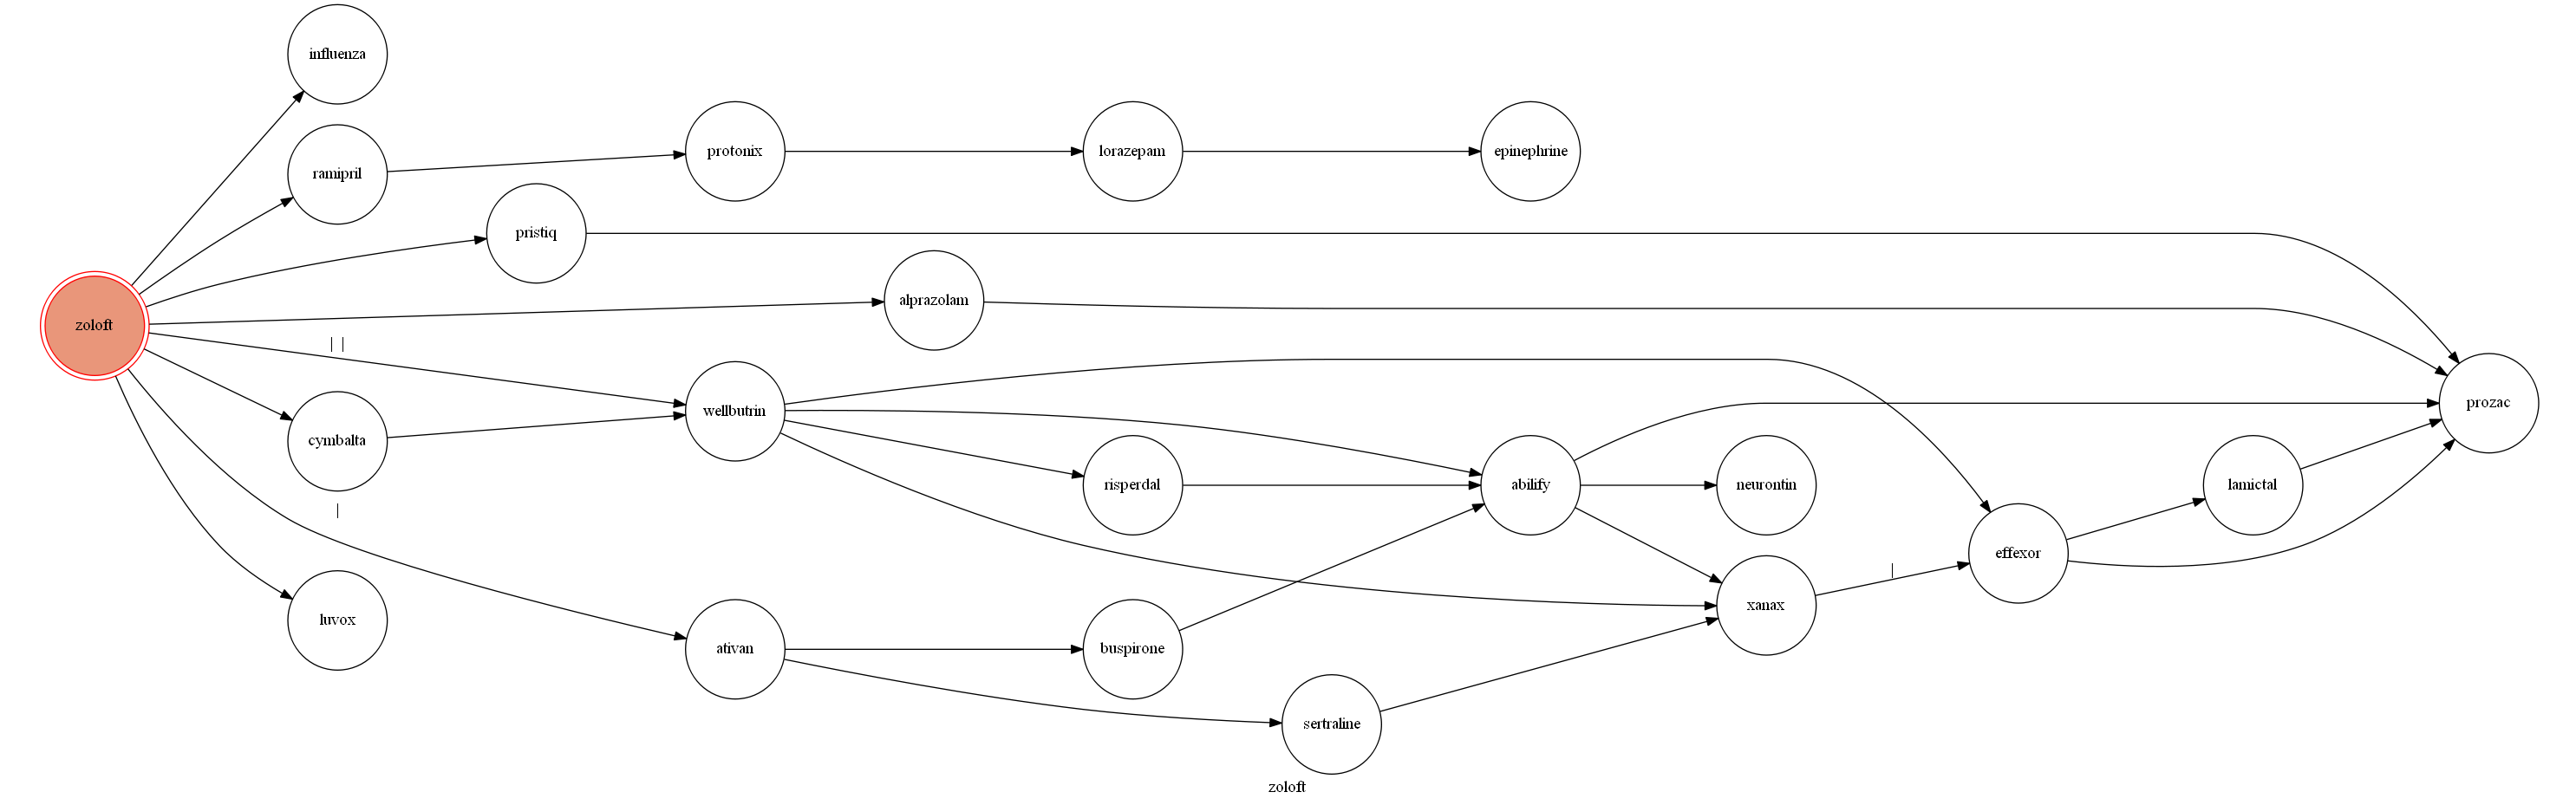

In [69]:
showDrugGraph('zoloft')

## Initialize tokenizers and stemmers

In [15]:
# create tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# conservative stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

texts = []

In [17]:
def strip_single_chars(tokens):
    return [i for i in tokens if len(i) > 1]

## Test on Data 

In [19]:
data = cleanedData

In [20]:
# Pre-processing for each post
for index, row in data.iterrows():
    raw = row['text'].lower()
    tokens = tokenizer.tokenize(raw)
    tokens = strip_single_chars(tokens)
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stems = [p_stemmer.stem(i) for i in stopped_tokens]
    texts.append(stems)

dictionary = corpora.Dictionary(texts)

In [21]:
dictionary.token2id

{'10': 558,
 '100': 346,
 '108': 156,
 '11': 43,
 '14': 8,
 '150': 355,
 '174': 860,
 '18': 256,
 '20': 496,
 '200': 367,
 '201': 166,
 '30': 797,
 '300': 679,
 '350': 647,
 '40': 450,
 '6mg': 446,
 '80': 368,
 '800': 209,
 '900': 841,
 'abil': 418,
 'abl': 485,
 'abnorm': 248,
 'absolut': 815,
 'absorpt': 629,
 'action': 58,
 'actual': 631,
 'add': 578,
 'addit': 502,
 'adject': 53,
 'adjust': 453,
 'adult': 183,
 'advanc': 338,
 'advers': 623,
 'advic': 419,
 'affect': 214,
 'age': 51,
 'agit': 264,
 'ago': 505,
 'akasthisia': 569,
 'akathisia': 251,
 'alcohol': 266,
 'alien': 801,
 'allerg': 241,
 'allevi': 507,
 'allow': 561,
 'almost': 341,
 'aloft': 498,
 'alon': 146,
 'along': 93,
 'alreadi': 423,
 'also': 175,
 'altern': 594,
 'alway': 615,
 'amazingli': 373,
 'amount': 294,
 'anna': 511,
 'anoth': 798,
 'ant': 690,
 'anti': 527,
 'anticholinerg': 715,
 'antidepress': 31,
 'antipsychot': 98,
 'anxieti': 307,
 'anxiou': 644,
 'anyon': 336,
 'anyth': 404,
 'anyway': 494,
 'apart'

In [22]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [23]:
ldamodel = gs.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)

In [24]:
ldamodel.print_topics(num_topics=10, num_words=3)

[(0, '0.030*latuda + 0.020*effect + 0.019*take'),
 (1, '0.026*latuda + 0.020*help + 0.017*hope'),
 (2, '0.036*take + 0.021*week + 0.019*help'),
 (3, '0.012*anxieti + 0.012*increas + 0.012*mayb'),
 (4, '0.010*take + 0.010*good + 0.010*get'),
 (5, '0.025*take + 0.021*latuda + 0.019*depress'),
 (6, '0.019*can + 0.019*give + 0.010*latuda'),
 (7, '0.031*feel + 0.021*anxieti + 0.011*take'),
 (8, '0.038*weight + 0.038*gain + 0.028*go'),
 (9, '0.051*latuda + 0.021*take + 0.016*may')]

# Nonsense code that I'm keeping for posterity

In [48]:
count_vect = CountVectorizer(min_df=15)
testing = count_vect.fit_transform(allPostsText)

In [49]:
vocab = count_vect.get_feature_names()
vocab = np.array(vocab)

In [61]:
dtm = testing.toarray()


In [44]:
slicedCleanData['symptomList'] = slicedCleanData.apply(lambda row: extractSymptoms(row), axis=1)

ValueError: could not broadcast input array from shape (4) into shape (6)

In [ ]:
cleanedData['drugList'] = cleanedData.apply(lambda row: extractDrugNames(row), axis=1)

In [116]:
def extract(string):
    second = string.split('(')[1]
    parenWords = re.findall(r"[\w-]+", second)
    return parenWords

In [117]:
def rxlistRowSplit(row):
    drugs = row['drug']
    drugWords = re.findall(r"[\w-]+", drugs)
    
    parenWords = extract(drugs)
    #print(drugWords)
    if len(drugWords) > 0:
        row['brandNameDrug'] = drugWords[0]
        row['medicalDrugName'] = parenWords[0]

        return row
    